# Chebyshev-PSOR Jacobi method for solving linear equations

Compairions of Jacobi method, Constant SOR, and Chebyshev PSOR: 

The linear equation $$P x = 0$$ is assumed without loss of generality where
$$P = I + M^T M \in \mathbb{R}^{512 \times 512}$$ is a diagonally dominant matrix.
Each element of $M$ follows ${\cal N}(0, 0.03^2)$. The minimum and maximum 
eigenvalues of $B = I-A$ are given by 
$\lambda_{max}(B) = 1.922$ and $\lambda_{min}(B) = 0.6766$, respectively.

The 3-curves represent the errors in Euclidean norm from the fixed-point, i.e., $||x^{(k)} - x^*||$ where
$x^*  = 0$.
The plain Jacobi method, Jacobi method with the optimal constant SOR factor, 
and Jacobi method accelerated by the Chebyshev PSOR are compared. 

The optimal constant SOR factor 
is given by $$\omega_{SOR} = 2/(\lambda_{min}(B) + \lambda_{max}(B)) = 0.7697$$

## Required packages

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
torch.manual_seed(0)

## Global constants

In [3]:
n = 512 # dimension of matrix 
max_itr = 25 # maximum number of itaration
T = 8 # period of Chebychev step

## Generation of symmetric diagonally dominant random matrix

In [4]:
M = torch.normal(torch.zeros(n,n), 0.03)
M = M.t() @ M
P = M + torch.eye(n)
D = torch.diag_embed(torch.diagonal(P))
R = P - D
Dinv = torch.inverse(D)
B = -Dinv @ R

## Evaluation of eigen value of $I-B$

In [5]:
lmax = torch.max(torch.eig(torch.eye(n)-B)[0].sum(dim=1)).item()
lmin = torch.min(torch.eig(torch.eye(n)-B)[0].sum(dim=1)).item()
print('lmax =', lmax)
print('lmin =', lmin)
print('condition number = ', lmax/lmin)

lmax = 1.921623706817627
lmin = 0.676575243473053
condition number =  2.8402217275249186


## q = 0 is assumed without loss of generality

In [6]:
q = torch.zeros(n,1)

## Jacobi method

Fixed-point iteraiton of Jacobi method is given by 
$$
	x^{(k+1)} = D^{-1} \left(q - (P - D) x^{(k)}  \right).
$$
where $D$ is the diagonal matrix whose diagonal elements are identical to the diagonal elements of $P$.


In [7]:
class Jacobi(nn.Module):
    def __init__(self, P, b):
        super(Jacobi, self).__init__()
        D = torch.diag_embed(torch.diagonal(P))
        self.R = P - D
        self.Dinv = torch.inverse(D)
        self.b = b

    def forward(self, num_itr):
        n = self.R.size()[0]
        x = torch.normal(torch.zeros(n,1), std=1.0)
        for i in range(num_itr):
            x = self.Dinv @ (self.b - self.R @ x)
        return x

## SOR Jacobi method

A constant SOR factor $\omega$ is assumed.
The SOR iteration is given by
$$
x^{(k+1)} = x^{(k)} + \omega\left( f( x^{(k)} ) - x^{(k)}  \right).
$$


In [8]:
class SOR_Jacobi(nn.Module):
    def __init__(self, P, b, omega):
        super(SOR_Jacobi, self).__init__()
        D = torch.diag_embed(torch.diagonal(P))
        self.R = P - D
        self.Dinv = torch.inverse(D)
        self.b = b
        self.omega = omega
    def forward(self, num_itr):
        n = self.R.size()[0]
        x = torch.normal(torch.zeros(n,1), std=1.0)
        for i in range(num_itr):
            tmp = self.Dinv @ (self.b - self.R @ x)
            x = x + self.omega*(tmp - x)
        return x

## Chebychev-PSOR Jacobi method

In [9]:
# Chebychev root
def c_root(k, a, b, T):
    return  (a + b)/2.0 + ((b - a)/2.0) * math.cos(math.pi * (2*k+1)/(2*T))

In [10]:
class Chebychev_SOR_Jacobi(nn.Module):
    def __init__(self, P, b):
        super(Chebychev_SOR_Jacobi, self).__init__()
        D = torch.diag_embed(torch.diagonal(P))
        self.R = P - D
        self.Dinv = torch.inverse(D)
        self.b = b
    def forward(self, num_itr, T):
        n = self.R.size()[0]
        x = torch.normal(torch.zeros(n,1), std=1.0)
        for i in range(num_itr):
            tmp = self.Dinv @ (self.b - self.R @ x)
            gamma = 1.0/c_root(i % T, lmin, lmax, T) # Chebychev step
            x = x + gamma * (tmp - x)
        return x

## Plot functions

In [11]:
def plot_pure_jacobi(P, q, color):
    norm_list = []
    jacobi = Jacobi(P, q)
    for i in range(max_itr):
        r = jacobi(i)
        norm_list.append(torch.norm(r))
    plt.plot(range(max_itr), norm_list, '.-', label='Jacobi', color=color, linestyle = "solid", linewidth=1, marker="s") 

In [12]:
def plot_sor_jacobi(P, b, color):
    norm_list = []
    omega_opt = 2.0/(lmax+lmin) # optimal constant SOR factor
    print('SOR omega = ', omega_opt)
    sor_jacobi = SOR_Jacobi(P, q, omega_opt)
    for i in range(max_itr):
        r = sor_jacobi(i)
        norm_list.append(torch.norm(r))
    plt.plot(range(max_itr), norm_list, '.-', label='Constant SOR (optimal)', color=color, linestyle = "solid", linewidth=1, marker="^") 

In [13]:
def plot_chebychev_sor_jacobi(T, P, b, label, color):
    chebychev_sor_jacobi = Chebychev_SOR_Jacobi(P, q)
    c_norm_list = []
    for i in range(max_itr):
        r = chebychev_sor_jacobi(i, T)
        c_norm_list.append(torch.norm(r))
    plt.plot(range(max_itr), c_norm_list, '.-', label=label, color=color, linestyle = "solid", linewidth=1, marker="o") 

## Plot of error curves (iteration step v.s. error in Euclidan norm)

SOR omega =  0.7697639935449304


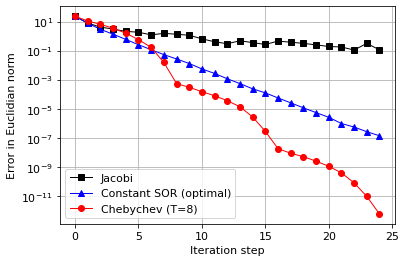

In [14]:
plt.rcParams["font.size"] = 11
plt.grid()
plt.yscale('log')
plt.xlabel('Iteration step')
plt.ylabel('Error in Euclidian norm')
plot_pure_jacobi(P, q, 'black') 
plot_sor_jacobi(P, q, 'blue') # maybe this is optimal for original SOR
plot_chebychev_sor_jacobi(8, P, q, 'Chebychev (T=8)', 'red')
plt.legend()
plt.savefig('jacobi.pdf')